## Part 1: Mixing Patterns and Assortativity

Let's dig in and try to understand more about the network of Computational Social Scientists using more advanced features. If your network has more than one component, just work on the giant connected component (GCC) in the exercises below. For the exercises below, you shall use the network you built in Week 4.

-----

### Exercise 1:  Mixing Patterns and Assortativity.

##### Loading graph:

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import networkx as nx
import netwulf as nw
from scipy import stats as st
import matplotlib.pyplot as plt

In [2]:
def load_graph():
    stylized_network, config, G = nw.load("Graph.json")
    print(G)
    with open('graphdata.pickle', 'rb') as file:
        attribute_dict = pickle.load(file)
    print(*[item for item in attribute_dict.items()][:3], sep='\n')
    nx.set_node_attributes(G, attribute_dict)
    return G

In [3]:
G = load_graph()

Graph with 45188 nodes and 975763 edges
(2122617020, {'_name_': 'Óscar Javier Galindo-caballero', 'top_field': ['Psychology'], 'median_citation_count': 0, 'paper_count': 0, 'first_paper_year': 'N/A'})
(78568827, {'_name_': 'Antonio Pais', 'top_field': ['Medicine'], 'median_citation_count': 0, 'paper_count': 0, 'first_paper_year': 'N/A'})
(2069946704, {'_name_': 'Nagarjuna Kumarappan', 'top_field': ['Psychology'], 'median_citation_count': 0, 'paper_count': 0, 'first_paper_year': 'N/A'})


1. For each node, compute the fraction of edges that connect to a node that works in the same top field. Find the average value across all nodes.

In [4]:
types_of_top_fields = []

def get_fractions(G, print_statements=False):
    fraction_of_edges_to_same_top_field = []

    for node in G.nodes:
        nodes = 0
        edges = 0
        try: top_fields = G.nodes[node]['top_field']
        except: continue
        if top_fields is None:
            continue
        for top_field in top_fields:
            if top_field not in types_of_top_fields:
                types_of_top_fields.append(top_field)
            for neighbor in G.neighbors(node):
                if "top_field" in G.nodes[neighbor]:
                    if G.nodes[neighbor]['top_field'] is None:
                        pass
                    elif top_field in G.nodes[neighbor]['top_field']:
                        edges += 1
                nodes += 1
        fraction_of_edges_to_same_top_field.append(edges/nodes)

    avg_fraction = sum(fraction_of_edges_to_same_top_field) / len(fraction_of_edges_to_same_top_field)
    if print_statements:
        print("First 10 fractions: ", [round(x, 3) for x in fraction_of_edges_to_same_top_field[:10]])
        print('Average fraction of edges connecting nodes in the same top field:', avg_fraction)
    return avg_fraction

original_avg_fractions = get_fractions(G, print_statements=True)

First 10 fractions:  [0.0, 0.0, 0.138, 0.182, 0.111, 0.176, 0.098, 0.333, 0.333, 0.0]
Average fraction of edges connecting nodes in the same top field: 0.07804470168233815


----
2. Create a new graph, with the same nodes and edges, but where the association between nodes and field is shuffled. Compute the measure above for this randomized graph.

Our way of solving this exercise was to make a list of unique types of top fields. We then ran over every single node and randomized the types of top_fields, but keeping the numbers of top_fields the same as before.

In [39]:
types_of_top_fields

['Sociology',
 'Political Science',
 'Computer Science',
 'Engineering',
 'Physics',
 'Mathematics',
 'Medicine',
 'Psychology',
 'Environmental Science',
 'Philosophy',
 'Geography',
 'Biology',
 'Economics',
 'History',
 'Materials Science',
 'Art',
 'Business',
 'Chemistry',
 'Geology']

In [40]:
import random

G_copy = G.copy()
node_list = list(G_copy.nodes())

In [42]:
attribute_dict = {}
for node in G_copy.nodes():
    try: top_fields = G.nodes[node]['top_field']
    except: attribute_dict[node] = {"top_field": None}; continue
    if top_fields is None:
        attribute_dict[node] = {"top_field": None}
    else:
        attribute_dict[node] = {"top_field": random.sample(types_of_top_fields, k=len(top_fields))}

nx.set_node_attributes(G_copy, attribute_dict)
get_fractions(G_copy, print_statements=True)

First 10 fractions:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.024, 0.0, 0.0, 0.0]
Average fraction of edges connecting nodes in the same top field: 0.010137278760206899


0.010137278760206899

This gives a much lower average fraction which is also expected as the connection between the nodes have been randomized

----
3. Repeat the point above 100 times (at least). Plot the distribution of the values obtained and compare it with the value you have found for the real graph. Is the chance to connect to a member of the same field significantly higher than it would be by chance?

We implement the scipt in 2. in a func

In [55]:
from tqdm import tqdm

def randomize_top_fields(number_of_times):
    values = []
    for i in tqdm(range(number_of_times)):
        G_copy = G.copy()
        node_list = list(G_copy.nodes())
        attribute_dict = {}
        for node in G_copy.nodes():
            try: top_fields = G.nodes[node]['top_field']
            except: attribute_dict[node] = {"top_field": None}; continue
            if top_fields is None:
                attribute_dict[node] = {"top_field": None}
            else:
                attribute_dict[node] = {"top_field": random.sample(types_of_top_fields, k=len(top_fields))}
        nx.set_node_attributes(G_copy, attribute_dict)
        values.append(get_fractions(G_copy))
    return values

def plot_distribution(fractions):
    plt.hist(fractions, bins=20, alpha=0.5, density=True)
    plt.axvline(x=original_avg_fractions, color='r')

    plt.xlabel('Fractions')
    plt.ylabel('Density')
    plt.title('Distribution of fractions of edges connecting nodes in the same top field in a randomized setting')
    plt.show()

In [53]:
fractions = randomize_top_fields(100)

100%|██████████| 100/100 [03:57<00:00,  2.38s/it]


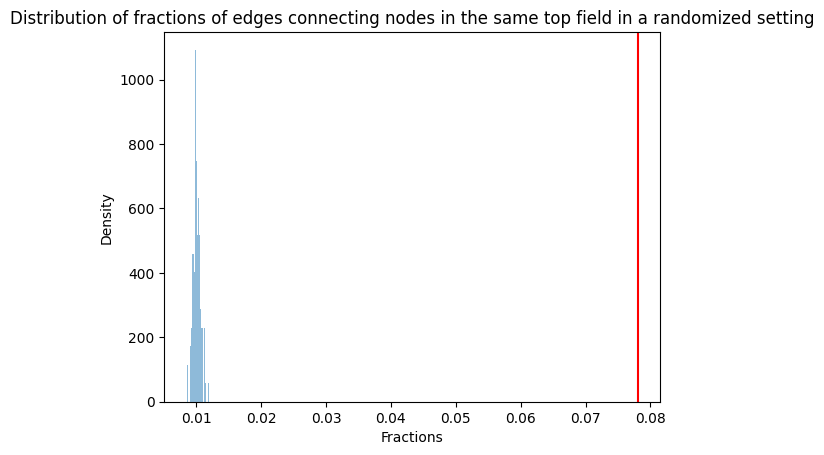

In [56]:
plot_distribution(fractions)

Where the red line is the average fraction in our graph G

In [61]:
mean = np.mean(fractions)
std = np.std(fractions)

print("For randomized settings:")
print("mean: ", mean)
print("std: ", std)
print("\n")

print("original average fraction: ", original_avg_fractions)
if original_avg_fractions < mean-2*std or original_avg_fractions > mean+2*std:
    print("Value is significantly different")
else: 
    print("Value is not significantly different")

For randomized settings:
mean:  0.010106881218046725
std:  0.0005725089237009744


original average fraction:  0.07804470168233815
Value is significantly different


Thereby we can conclude that the chance to connect to a member of the same field is significantly higher than it would be by chance

----
4. Compute the assortativity coefficient with respect to author's field. How do you interpret the value you obtain? (Hint: See this paper, eq (2)). Important: here I do not want you to use the NetworkX implementation, but rather to implement your own version of the measure.

Our own implementation:

In [20]:
def assortativity_coefficient(G):
    degrees = dict(G.degree())
    sum_degrees = sum([deg for node, deg in degrees.items()])
    sum_top_fields = 0

    for u, v in G.edges():
        try: top_field1 = G.nodes[u]['top_field']; top_field2 = G.nodes[v]['top_field']
        except: continue
        if top_field1 is None or top_field2 is None:
            continue
        sum_top_fields += (sum([1 if x == y else 0 for x, y in zip(top_field1, top_field2)])/len([1 if x == y else 0 for x, y in zip(top_field1, top_field2)]))
        
    r = (sum_top_fields - sum_degrees) / (1 - sum_degrees)
    return r

In [21]:
def assortativity_coefficient_alternative(G):
    degrees = dict(G.degree())
    sum_degrees = sum([deg for node, deg in degrees.items()])
    sum_degrees_sq = sum_degrees ** 2
    sum_sq_degrees = sum([deg**2 for node, deg in degrees.items()])
    sum_top_fields = 0

    for u, v in G.edges():
        try: top_field1 = G.nodes[u]['top_field']; top_field2 = G.nodes[v]['top_field']
        except: continue
        if top_field1 is None or top_field2 is None:
            continue
        sum_top_fields += sum([1 if x == y else 0 for x, y in zip(top_field1, top_field2)])
        
    r = (sum_top_fields * sum_degrees - sum_degrees_sq) / (sum_sq_degrees - sum_degrees_sq)
    return r

In [22]:
assortativity_coefficient(G), assortativity_coefficient_alternative(G)

(0.9909350379831158, 0.9908555414023319)

We get an extremely high in both of our implementations. We tried to make another alternative as we found that the first implement was very high, but the second implementation (which is very much alike, but uses another formula) seems to be just as high. This convinces us that the assortative mixing is near perfect when it comes to top_fields. This means that the individuals in the graph has a extremely high tendency to form connections with others who are similar to themselves. 

----
5. Is the graph assortative with respect to the degree? (e.g. do high-degree scientists tend to link to other high-degree scientists, and low-degree scientists to other low-degree scientists?). Provide an interpretation of your answer.

To compute this we can simply use networkx implementation, which should work completely fine for this problem:

In [8]:
r = nx.degree_assortativity_coefficient(G)
print(f"Assortativity coefficient r = {r:.3f}")

Assortativity coefficient r = 0.575


As we were unsure if our own function was needed we also created this:

In [23]:
def degree_assortativity_coefficient(G):
    degrees = dict(G.degree())
    sum_degrees = sum([a*b for a,b in zip(degrees.values(), degrees.values())])
    equal_degree, not_equal_degree = 0, 0
    degree_assortativity = 0
    for u, v in G.edges():
        if degrees[u] == degrees[v]:
            equal_degree += 1
            degree_assortativity += degrees[u] * degrees[v]
        not_equal_degree += 1

    r = (degree_assortativity - sum_degrees) / (1 - sum_degrees)
    print(f"Number of equal degrees: {equal_degree}")
    print(f"Number of not equal degrees: {not_equal_degree}")
    return r

print(f"Assortativity coefficient r = {degree_assortativity_coefficient(G):.3f}")

Number of equal degrees: 13099
Number of not equal degrees: 975763
Assortativity coefficient r = 0.566


We can see that our implementation gives nearly the same value as networkx' implementation. This could be due to them using another formula and to the fact that this value has some small error around it.

A value of .566 shows that the graph assortative with respect to the degree is decently high, although not as high as top_fields. High degree scientist often link to other high degree scientist, but there is also a bunch of connections between high degree and low degree scientists, or at least where the degree is different. The value shows that this assortative is stronger than a completely random/useless assortative which would have a value of around 0. (or actually closer to .1 as we saw in above in the randomized settings).

----